<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Coding AdaBoost From Scratch

_Authors: Kiefer Katovich (SF)_

---

> **Note:** This code-along is intended to be completed with the instructor.

Below we will be coding the AdaBoost algorithm from scratch, then visualizing the results as weak learners are chained onto the meta-estimator.


In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Random toy data set for classification visualization.
from sklearn.datasets import make_moons 
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## AdaBoost Algorithm, Part 1

---

Recall:

### $$ AdaBoost(X) = sign\left(\sum_{t=1}^T\alpha_t h_t(X)\right) $$

Where:

$AdaBoost(X)$ is the classification predictions for $y$ using predictor matrix $X$.

$T$ is the set of weak learners.

$\alpha_t$ is the contribution weight for weak learner $t$.

$h_t(X)$ is the prediction of weak learner $t$.

$y$ is binary **with values of negative one and one**.

### 1) Write the AdaBoost estimator function based on the algorithm described above.

Your function will need arguments:

- `X`: The design matrix.
- `estimators`: The weak learners.
- `alphas`: The contribution weight of each weak learner.

We'll be using this later.

In [3]:
def adaboost(X, estimators, alphas):
    # Initialized with all zeros.
    yhat = np.zeros(X.shape[0])
    
    # Zips the pairs of alpha estimators.
    for alpha, est in zip(alphas, estimators):
        # If the prediction correctly assigns one, incorrectly assign negative one.
        prediction = [1 if y == 1 else -1 for y in est.predict(X)]
        # Multiply the results by the estimator’s weight.
        prediction = np.array(prediction) * alpha
        # Appends weighted predictions to yhat results.
        yhat = yhat + prediction
        
    # Converts yhat's values into negative one, zero, and one. 
    yhat = np.sign(yhat)
    # Only keeps correct answers at one value; everything else is converted to zero.
    yhat = np.array([1 if y == 1 else 0 for y in yhat])
    return yhat

## AdaBoost Algorithm, Part 2

---

The weak learner classifiers are trained sequentially. After each fit, the importance weights on each observation need to be updated. AdaBoost, like all boosting ensemble methods, focuses the next model's fit on the misclassifications/weaknesses of the prior models.

All training examples start with equal importance weighting. When we finish training a classifier, we update the importance weighting of the classifier, represented by alpha $\alpha$.

### $$ \alpha_t = \frac{1}{2}ln \left(\frac{1-\epsilon_t}{\epsilon_t}\right) \text{where } \epsilon_t < 1$$

Where $\epsilon_t$ is the misclassification rate for the current classifier:

### $$ \epsilon_t = \frac{\text{misclassifications}_t}{\text{observations}_t} $$



### 2) Write a function to calculate the alpha weight.

The function will take arguments:

- `y`: Yhe vector of true target values.
- `y_hat`: The vector of predictions.

In [4]:
def calculate_alpha(y_true, predictions):
    # Error = 1 — mean classification rate.
    error_rate = 1. - np.mean(y_true == predictions)
    return np.log((1. - error_rate) / error_rate) * 0.5

In [5]:
# Taking the mean of a Boolean comparison will return an int.
# Example:

print(np.mean([0 == 0, 1==1])) # np.mean(1,1))
print(np.mean([0 == 0, 1==0])) # np.mean(1,0))
print(np.mean([False, False])) # np.mean(0,0))

1.0
0.5
0.0


## AdaBoost Algorithm, Part 3

---

AdaBoost sets up a weight vector on the observations, denoted as $D_t$ where $t$ is the current model iteration. $D_t$ is a probability distribution that determines how likely it is that a given observation will be selected as part of the training set for the current estimator.

The $\alpha$ weighting of the last fit estimator is used in the equation for the weighting distribution. The updated equation is:

### $$ D_{t+1}(i) = D_t(i) e^{-\alpha_t y_i h_t(x_i)} $$

Where $i$ is the vector of observation indices and $x_i$ is the observation at the index, $y_i$ is the target.

$h_t$ is the previous model fit in the boosting chain.

Then, divide the weights by the sum of weights to normalize them, ensuring that they sum to one and form a probability distribution:

### $$ D_{t+1}(i) = \frac{D_{t+1}(i)}{\sum_{i=1}^N D_{t+1}(i)}$$


### 3) Write a function to update the importance weights.

The function will take arguments:

- `X`: The design matrix.
- `y`: The vector of target values.
- `current_D`: The current weights on observations.
- `alpha`: The weight on the current estimator.
- `estimator`: The current weak learner.

In [6]:
def update_importance_weights(X, ytrue, current_D, alpha, estimator):
    y_true_signed = np.array([1 if y == 1 else -1 for y in ytrue])
    y_hat_signed = np.array([1 if y == 1 else -1 for y in estimator.predict(X)])
    
    updated_D = current_D * np.exp((-alpha * y_true_signed * y_hat_signed))
    updated_D = updated_D / np.sum(updated_D)
    return updated_D

### 4) Write a function that will sample observations according to weightings.

The function will take arguments:

- `X`: The design matrix.
- `y`: The vector of target values.
- `D`: The probability weights on observations.

In [7]:
def sample_with_weights(X, y, D):
    indices = np.arange(X.shape[0])
    # Randomizes features being used in each set. ### choosing random rows
    random_indices = np.random.choice(indices, size=X.shape[0], replace=True, p=D)
    return X[random_indices, :], y[random_indices]

In [18]:
X[[7,9,29],:]

array([[-0.63477334,  0.41968413],
       [-0.01309764, -0.34098031],
       [ 1.9360994 ,  0.25704719]])

### 5) Create some fake data (provided).

In [8]:
# Once again, make_moons is a random data set for visualizing classifications. 
moons = make_moons(n_samples=30, noise=0.75, random_state=42)
X, y = moons
X = StandardScaler().fit_transform(X)

# Create separate sample areas.
x_min, x_max = X[:, 0].min() - 1.0, X[:, 0].max() + 1.0
y_min, y_max = X[:, 1].min() - 1.0, X[:, 1].max() + 1.0
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

### 6) Write a function to plot the current AdaBoost iteration (provided).

In [9]:
def plot_adaboost(X, y, xx, yy, clf, D):
    from matplotlib.colors import ListedColormap

    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    # Put the result in a color plot.
    Z = Z.reshape(xx.shape)
    
    fig, ax = plt.subplots(figsize=(9,7))
    
    ss = [30 + 2500*w for w in D]

    cm_dark = ListedColormap(['#1F77B4', '#FF7F0E'])
    cm_light = ListedColormap(['#729ECE', '#FF9E4A'])
    # Plot the training points.
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_dark, s=ss)

    ax.contourf(xx, yy, Z, cmap=cm_light, alpha=.25)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())

    plt.show()

### 7) Iterate the AdaBoost algorithm through 10 iterations, with each iteration adding a new weak learner.

This will need to follow the procedure outlined in the algorithm formulas above.

You will need to keep track of:

- `D`: The probability weights for sampling observations.
- A list of estimators (weak learners).
- A list of alpha weightings on each weak learner.

At each iteration, plot AdaBoost with the function provided above and calculate the accuracy of the entire ensemble model.

ITERATION: 0
Accuracy: 0.7333333333333333
ITERATION: 1
Accuracy: 0.8666666666666667


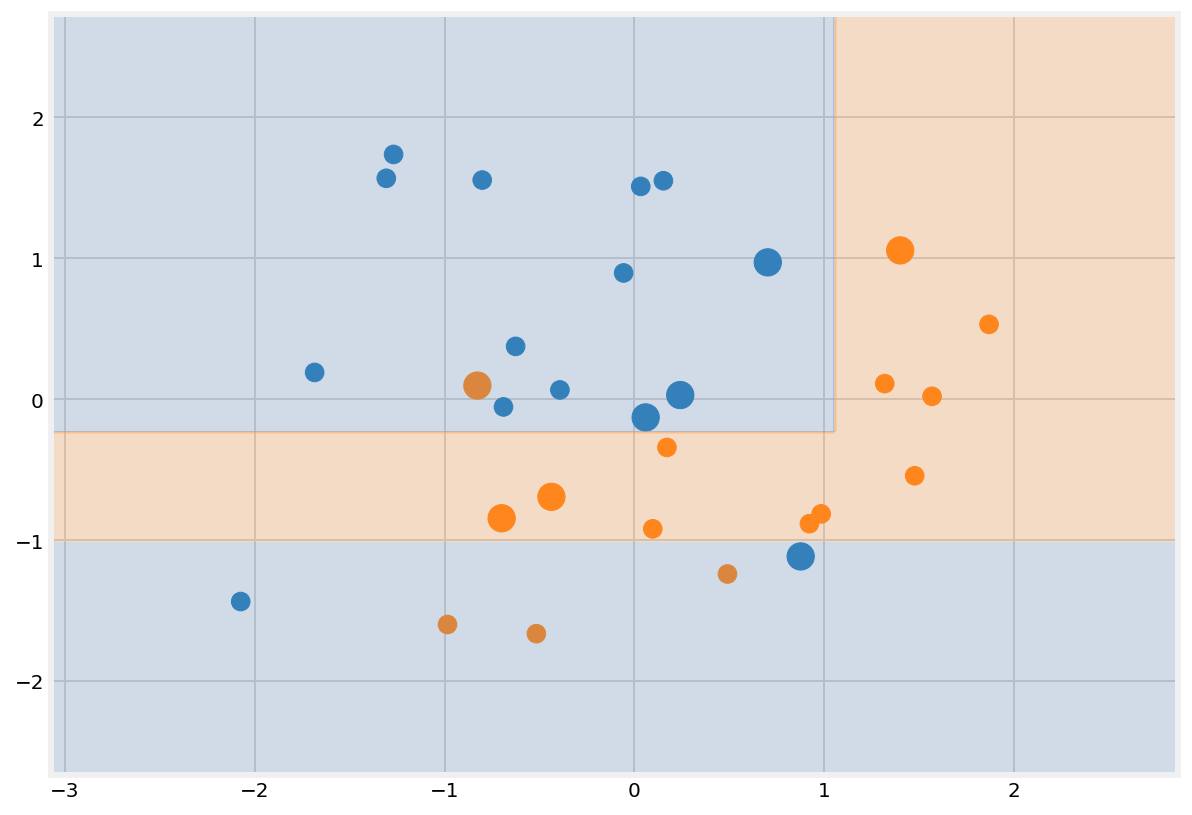

ITERATION: 2
Accuracy: 0.9


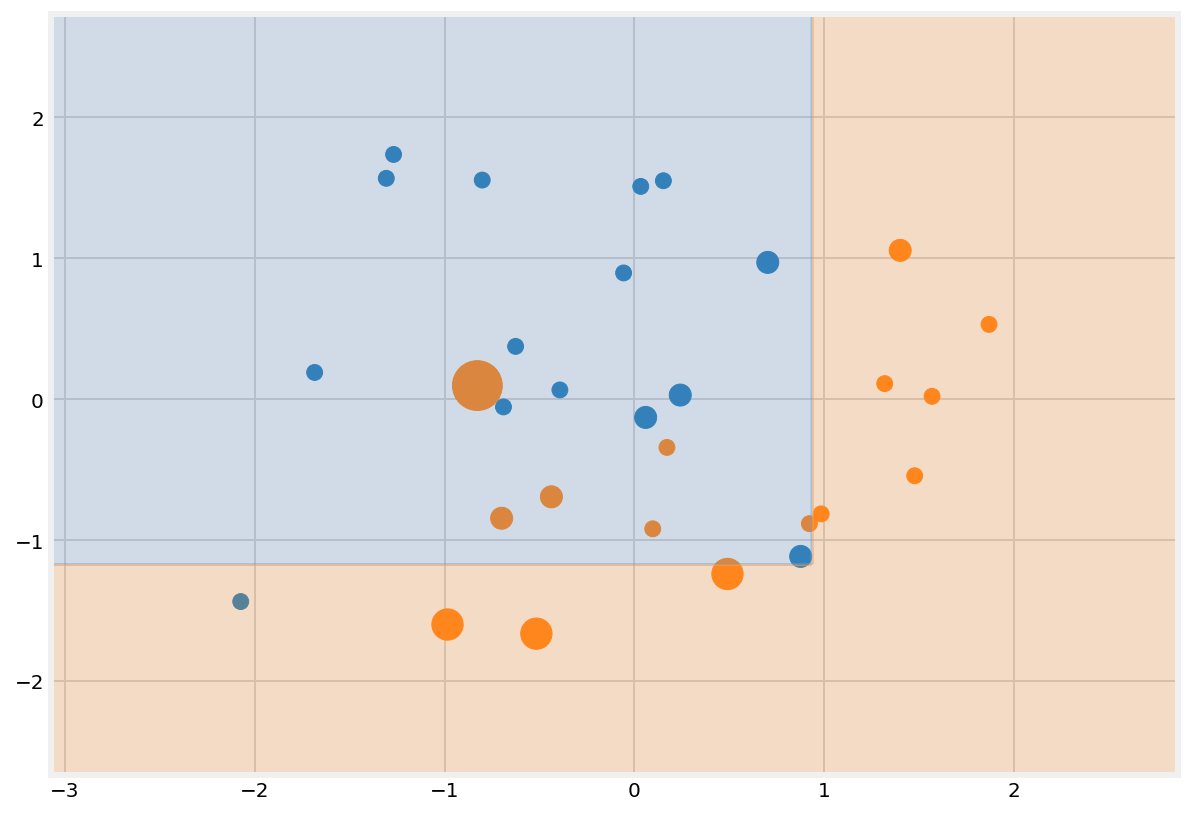

ITERATION: 3
Accuracy: 0.8


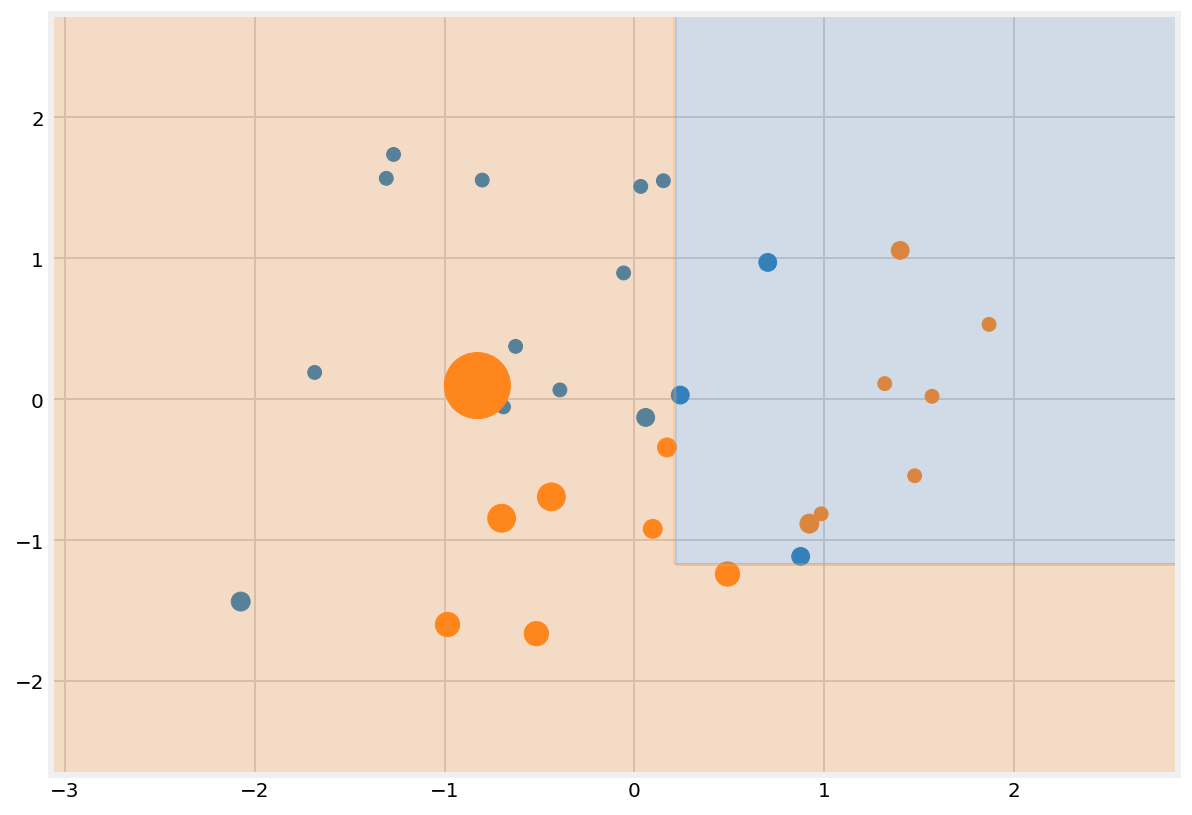

ITERATION: 4
Accuracy: 0.8333333333333334


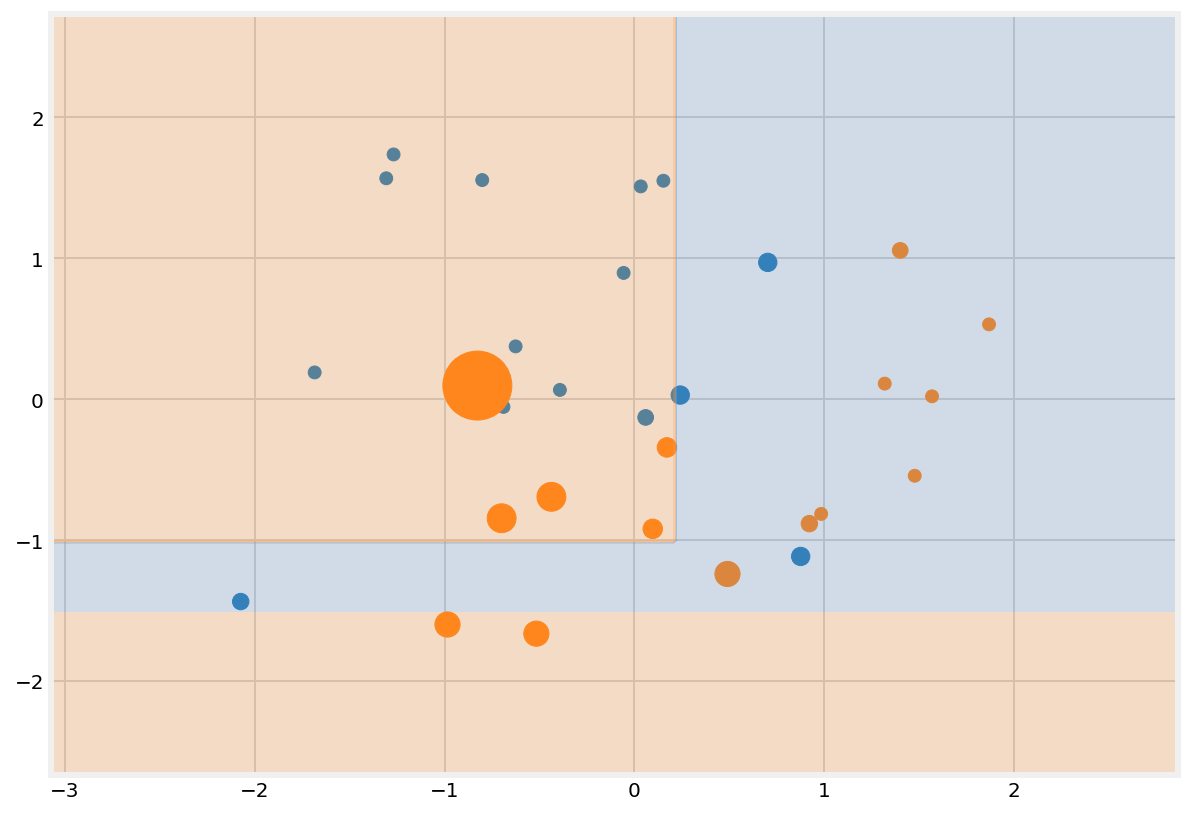

ITERATION: 5
Accuracy: 0.8333333333333334


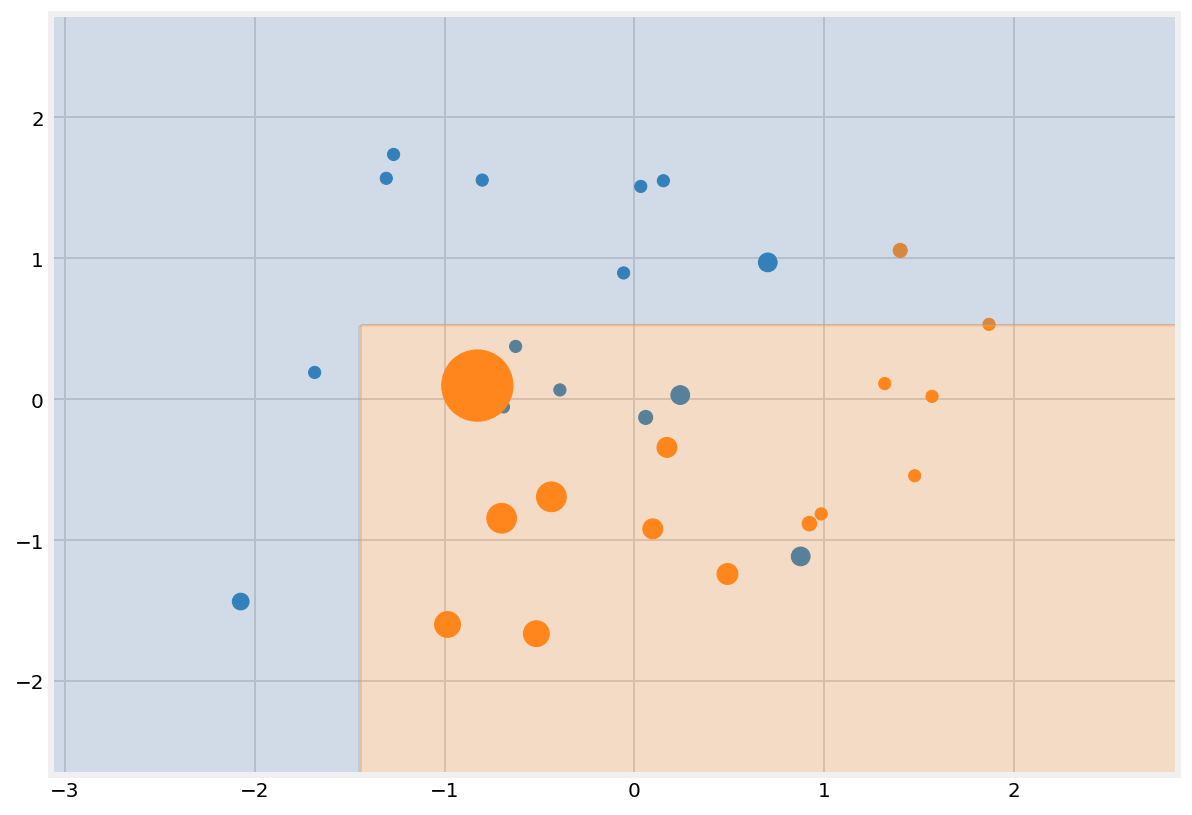

ITERATION: 6
Accuracy: 0.9666666666666667


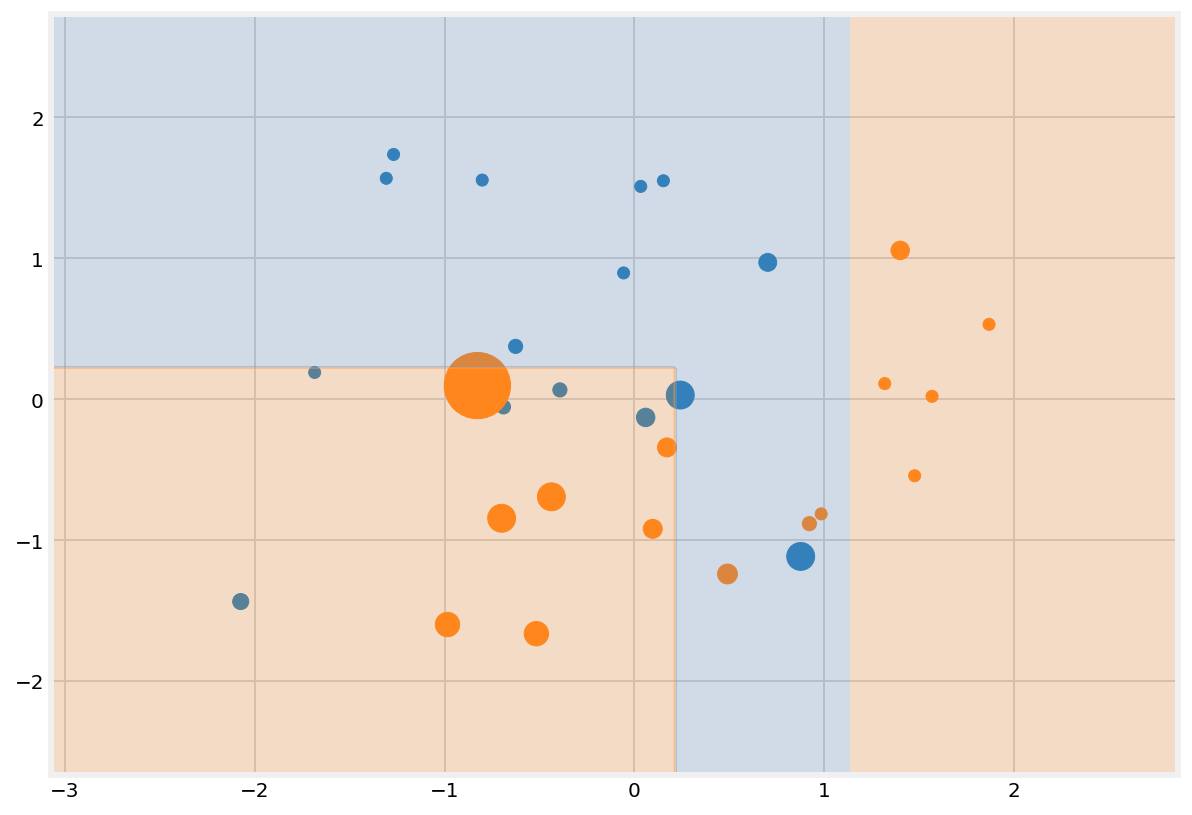

ITERATION: 7
Accuracy: 0.9333333333333333


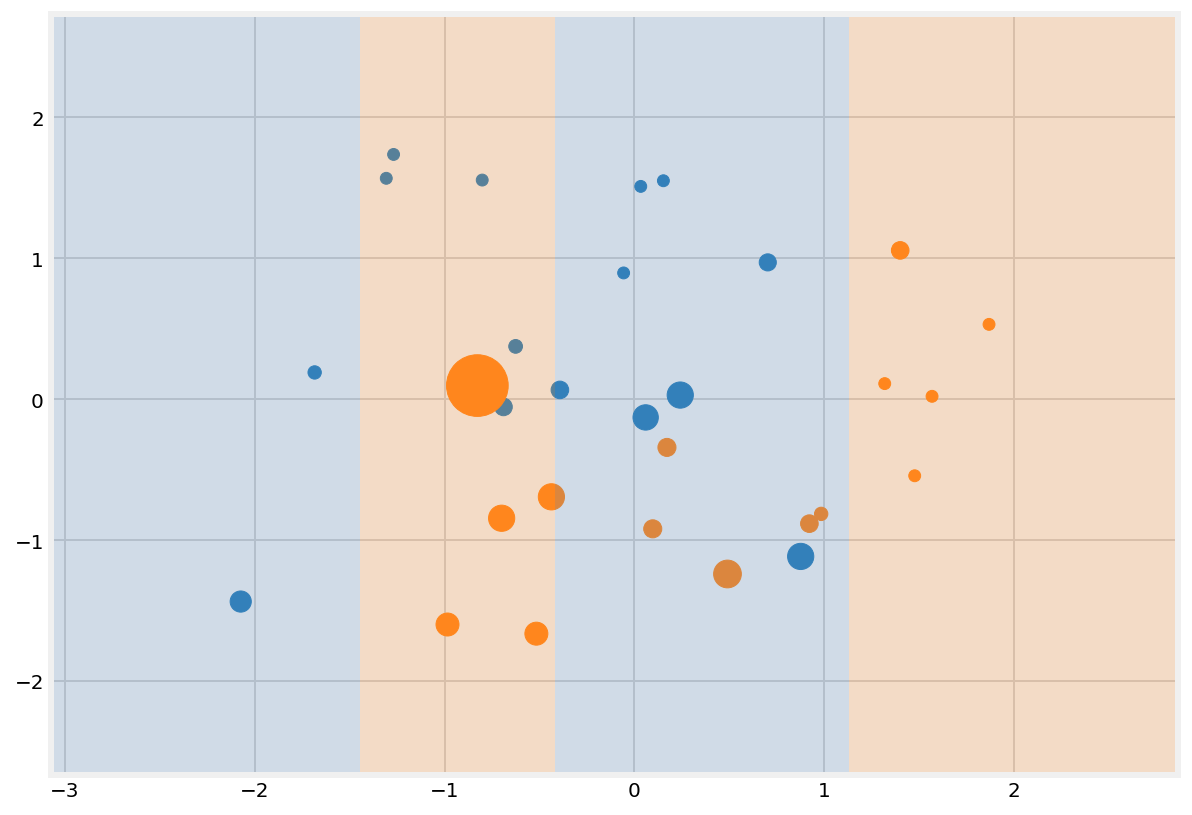

ITERATION: 8
Accuracy: 0.9666666666666667


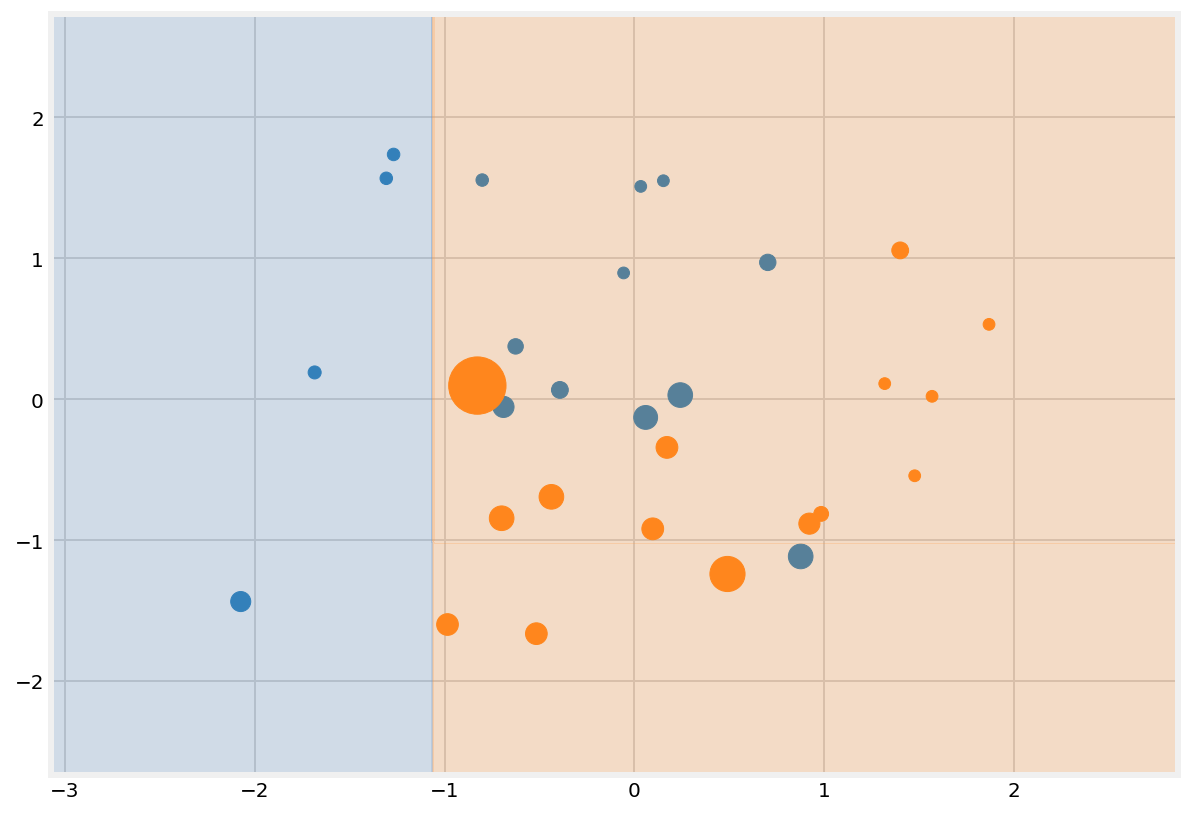

ITERATION: 9
Accuracy: 0.9666666666666667


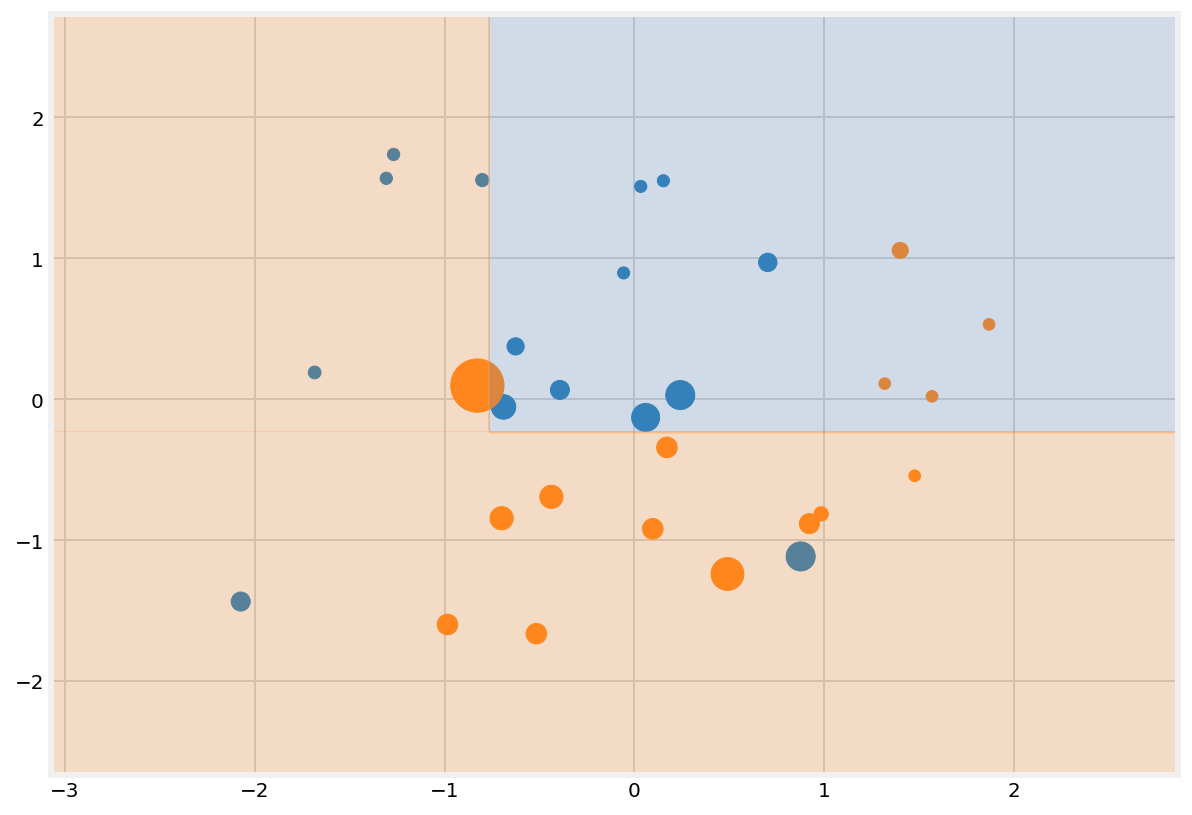

In [10]:
n_estimators = 10
D = np.ones(len(y))/len(y)

estimators = []
alphas = []
Ds = []

for i in range(n_estimators):
    print('ITERATION:', i)
    X_boot, y_boot = sample_with_weights(X, y, D)
    dtc = DecisionTreeClassifier(max_depth=2)
    dtc.fit(X_boot, y_boot)
    
    yhat = dtc.predict(X)
    alpha = calculate_alpha(y, yhat)
    
    D = update_importance_weights(X, y, D, alpha, dtc)
    
    estimators.append(dtc)
    alphas.append(alpha)
    Ds.append(D)
    
    ada_predictions = adaboost(X, estimators, alphas)
    print('Accuracy:', np.mean(y == ada_predictions))
    
    if i > 0:
        plot_adaboost(X, y, xx, yy, dtc, Ds[-2])

### Playground

In [11]:
moons = make_moons(n_samples=300, noise=0.5, random_state=42)
X, y = moons
X = StandardScaler().fit_transform(X)

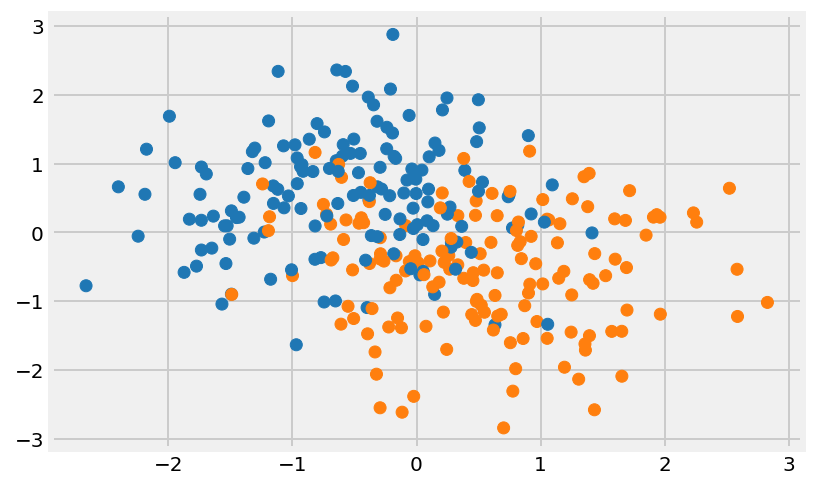

In [12]:
cm_dark = ListedColormap(['#1F77B4', '#FF7F0E'])
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_dark)

In [13]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

scores_test = []
scores_train = []
n_estimators = []

for n_est in range(30):
    ada = AdaBoostClassifier(n_estimators=n_est+1, random_state=42)
    ada.fit(X_train, y_train)
    n_estimators.append(n_est+1)
    scores_test.append(ada.score(X_test, y_test))
    scores_train.append(ada.score(X_train, y_train))

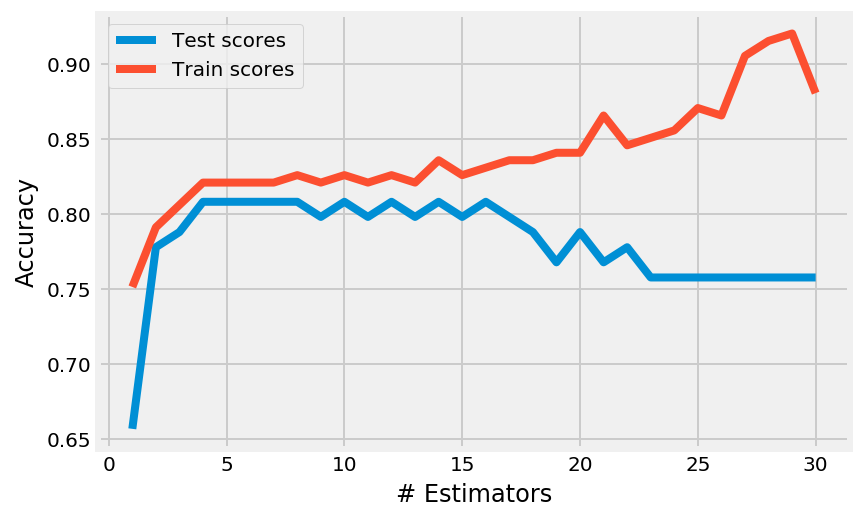

In [14]:
plt.plot(n_estimators, scores_test, label='Test scores')
plt.plot(n_estimators, scores_train, label='Train scores')
plt.xlabel('# Estimators')
plt.ylabel('Accuracy')
plt.legend()

In [15]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

scores_test = []
scores_train = []
n_estimators = []

for n_est in range(30):
    grb = GradientBoostingClassifier(n_estimators=n_est+1, random_state=42)
    grb.fit(X_train, y_train)
    n_estimators.append(n_est+1)
    scores_test.append(grb.score(X_test, y_test))
    scores_train.append(grb.score(X_train, y_train))

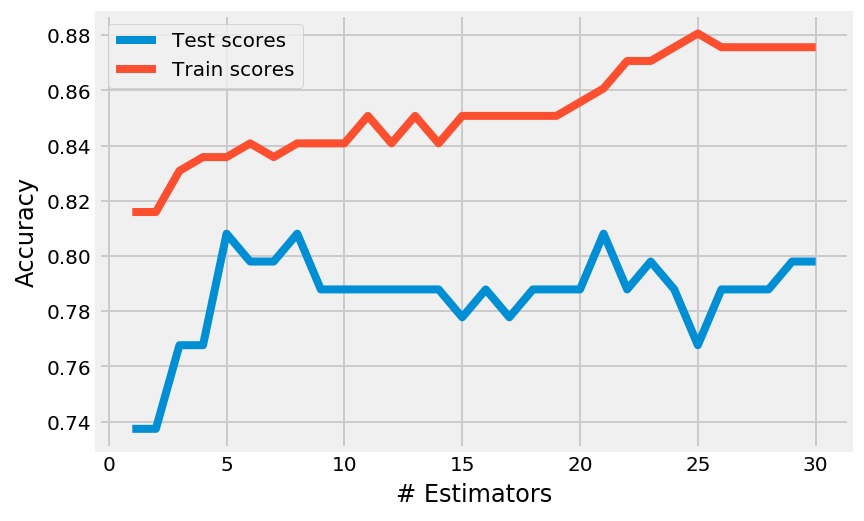

In [16]:
plt.plot(n_estimators, scores_test, label='Test scores')
plt.plot(n_estimators, scores_train, label='Train scores')
plt.xlabel('# Estimators')
plt.ylabel('Accuracy')
plt.legend()